# Data Analysis

***

**Owner:** Ling-Yun, Huang

**Project Title:** Enhance Road Safety, Focusing on Pedestrian: Using Taipei Traffic Accident Data in 2020-2022.


***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chi-squared test & Logistic Regression
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

# Deal with data imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Random Foret model train
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Print the version of each library
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
import matplotlib
print(f'matplotlib version: {matplotlib.__version__}')
print(f'seaborn version: {sns.__version__}')

import scipy
print(f'scipy version: {scipy.__version__}')
import statsmodels
print(f'statsmodels version: {statsmodels.__version__}')
import imblearn
print(f'imblearn version: {imblearn.__version__}')
import sklearn
print(f'sklearn version: {sklearn.__version__}')

pandas version: 2.1.1
numpy version: 1.26.0
matplotlib version: 3.8.0
seaborn version: 0.13.0
scipy version: 1.11.1
statsmodels version: 0.14.0
imblearn version: 0.11.0
sklearn version: 1.3.0


In [2]:
# import prepared dataset

# Load datasets from Pickle files
df_accident = pd.read_pickle('df_accident.pkl')
df_individual = pd.read_pickle('df_individual.pkl')
Pedestrian_accident = pd.read_pickle('Pedestrian_accident.pkl')
Pedestrian_individual = pd.read_pickle('Pedestrian_individual.pkl')

*Now we prepare all the datasets and ready for the analysis.*
- df_accident : Contain all accident-based data with vehicles involve.
- df_individaul : Contain all individaul-based data with its vehicle use.
- Pedestrian_accident : Contian all pedestrian-related accident with key factors.
- Pedestrian_individual : Contain all pedestrian data with its accident condition and driver's information.

### Table 1-1: Total fatal count of Accidents

In [3]:
# Count the overall number of fatal and non-fatal accidents.
df_accident.Fatal.value_counts()

Fatal
0    74967
1      262
Name: count, dtype: int64

In [4]:
# With different vehicles, count the number of fatal and non-fatal accidents.
Bus_fatal = pd.crosstab(df_accident.involve_bus > 0, df_accident.Fatal)
Bus_fatal = Bus_fatal[Bus_fatal.index == True]
Bus_fatal['codebook'] = 'Bus/Truck'
Car_fatal = pd.crosstab(df_accident.involve_car > 0, df_accident.Fatal)
Car_fatal = Car_fatal[Car_fatal.index == True]
Car_fatal['codebook'] = 'Sedan/Small Truck'
Scooter_fatal = pd.crosstab(df_accident.involve_scooter > 0, df_accident.Fatal)
Scooter_fatal = Scooter_fatal[Scooter_fatal.index == True]
Scooter_fatal['codebook'] = 'Motorcycle/Scooter'
Bicycle_fatal = pd.crosstab(df_accident.involve_bicycle > 0, df_accident.Fatal)
Bicycle_fatal = Bicycle_fatal[Bicycle_fatal.index == True]
Bicycle_fatal['codebook'] = 'Bicycle'
Pedestrian_fatal = pd.crosstab(df_accident.involve_pedestrian > 0, df_accident.Fatal)
Pedestrian_fatal = Pedestrian_fatal[Pedestrian_fatal.index == True]
Pedestrian_fatal['codebook'] = 'Pedestrian'
Other_fatal = pd.crosstab(df_accident.involve_other > 0, df_accident.Fatal)
Other_fatal = Other_fatal[Other_fatal.index == True]
Other_fatal['codebook'] = 'Other vehicle'
People_fatal = pd.crosstab(df_accident.involve_people > 0, df_accident.Fatal)
People_fatal = People_fatal[People_fatal.index == True]
People_fatal['codebook'] = 'Passenger/Other people'

Fatal_count = pd.concat([Bus_fatal,Car_fatal,Scooter_fatal,Bicycle_fatal,
                         Pedestrian_fatal,Other_fatal,People_fatal], ignore_index=True)
Fatal_count.index = range(1, len(Fatal_count)+1)
Fatal_count

Fatal,0,1,codebook
1,2496,33,Bus/Truck
2,45229,149,Sedan/Small Truck
3,66664,177,Motorcycle/Scooter
4,4238,23,Bicycle
5,6150,101,Pedestrian
6,327,2,Other vehicle
7,10118,26,Passenger/Other people


### Table 1-2: Total injury degree count of individaul

In [5]:
Injury_involve = pd.crosstab(df_individual['Category_grouping'],df_individual['Injury_level'])
codebook = {1:'Bus/Truck',2:'Sedan/Small Truck',3:'Motorcycle/Scooter',
            4:'Bicycle',5:'Pedestrian',6:'Other vehicle',7:'Passenger/other people'}
Injury_involve['Codebook'] = Injury_involve.index.map(codebook.get)

# 0:'Death within 24 hours', 1:'Death within 30 days', 2:'Injury', 3:'Non-injury'
Injury_involve.sort_index()

Injury_level,0.0,1.0,2.0,3.0,Codebook
Category_grouping,,,,,
1,0,0,48,2402,Bus/Truck
2,6,1,2469,46072,Sedan/Small Truck
3,93,31,77015,13639,Motorcycle/Scooter
4,11,9,3908,491,Bicycle
5,73,28,6103,277,Pedestrian
6,1,0,124,196,Other vehicle
7,9,1,10079,685,Passenger/other people


### Table 2: Risk factors of fatal accident that involve pedestrian.

In [6]:
# function of chi-square test result with Fatal accident
def chi2_PedFatal(col, codebook={}):
    crosstab = pd.crosstab(Pedestrian_accident[col], Pedestrian_accident.Fatal)
    chi2, p, dof, expected = chi2_contingency(crosstab)
    crosstab['Codebook'] = crosstab.index.map(codebook.get)
    
    print(crosstab)
    print(f'p-value: {p:.3f}')
    print('')

In [7]:
# Casue of accident
codebook = {1:'Driver - Improper driving at pedestrian crossing',2:'Driver - Not paying enough attention',
            3:'Driver - Other causes',4:'Pedestrians fail to comply with regulations',5:'Unable to identify'}
chi2_PedFatal('Cause_major_gp', codebook)

# Weather condition
codebook = {1:'Sunny',2:'Cloudy',3:'Rainy'}
chi2_PedFatal('Weather_gp', codebook)

# Light condition
codebook = {1:'Natural daylight',2:'Night or early morning'}
chi2_PedFatal('Light_gp', codebook)

# Road Surface condition
codebook = {0:'Dry',1:'Slippery'}
chi2_PedFatal('Road_surface', codebook)

# Road Type
codebook = {1:'Intersection',2:'Straight road',3:'Other'}
chi2_PedFatal('Road_type_gp', codebook)

# Road edge condition
codebook = {0:'With road edge',1:'Without road edge'}
chi2_PedFatal('Road_edge', codebook)

# Driver's vehicle
codebook = {1:'Bus or Truck',2:'Sedan or Small Truck',3:'Motorcycle or Scooter',
            4:'Bicycle',5:'Other or mix'}
chi2_PedFatal('Driver_vehicle', codebook)

# Season
codebook = {1:'Spring',2:'Summer',3:'Autumn',4:'Winter'}
chi2_PedFatal('Season', codebook)

# Day of the week
codebook = {1:'Weekend', 0:'Weekday'}
chi2_PedFatal('is_Weekend', codebook)

# Time of the day
codebook = {1:'Midnight (12am-7am)', 2:'Morning Rush hour (7am-9am)', 3:'Midday (9am-5pm)',
            4:'Afternoon Rush hour (5pm-7pm)', 5:'Evening and Night(7pm-12am)'}
chi2_PedFatal('Hour_gp', codebook)

# Location
codebook = {1:'North',2:'West',3:'South',4:'East',5:'Central'}
chi2_PedFatal('Location', codebook)

Fatal              0   1                                          Codebook
Cause_major_gp                                                            
1.0             2318  35  Driver - Improper driving at pedestrian crossing
2.0             1365  27              Driver - Not paying enough attention
3.0              720   9                             Driver - Other causes
4.0              763  17       Pedestrians fail to comply with regulations
5.0              840  11                                Unable to identify
p-value: 0.415

Fatal          0   1 Codebook
Weather_gp                   
1           3448  49    Sunny
2           1055  21   Cloudy
3           1647  31    Rainy
p-value: 0.310

Fatal        0   1                Codebook
Light_gp                                  
1         3494  47        Natural daylight
2         2656  54  Night or early morning
p-value: 0.049

Fatal            0   1  Codebook
Road_surface                    
0             4358  67       Dry
1     

There are five variables that have p < 0.1 in chi-squared test. I will use Logistic regression model to further assess these variables together.
- Light condition
- Road Type
- Road Edge condition
- Driver's vehicle
- Time of the day

Since "Light condition" and "Time of the day" are both highly correlated with time, I will only put "Time of the day" inside the Logistic regression.

Logistic regression's coding refered to Andrew Villazon. (https://www.andrewvillazon.com/logistic-regression-python-statsmodels/)

In [8]:
## Logistic regression
formula="Fatal~C(Road_type_gp)+C(Road_edge)+C(Driver_vehicle,Treatment(reference=2))+C(Hour_gp,Treatment(reference=3))"
log_reg = smf.logit(formula, data=Pedestrian_accident).fit()

# Calculate OR
odds_ratios = pd.DataFrame(
    {
        "OR": np.exp(log_reg.params),
        "Lower CI": np.exp(log_reg.conf_int()[0]),
        "Upper CI": np.exp(log_reg.conf_int()[1]),
        "p-value": log_reg.pvalues
    }
)

pd.options.display.float_format = '{:.3f}'.format
odds_ratios

Optimization terminated successfully.
         Current function value: 0.077885
         Iterations 21


/Users/lynnhuang/anaconda3/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,OR,Lower CI,Upper CI,p-value
Intercept,0.008,0.004,0.016,0.000
C(Road_type_gp)[T.2],0.922,0.590,1.441,0.723
C(Road_type_gp)[T.3],0.342,0.083,1.413,0.138
C(Road_edge)[T.1],1.543,0.908,2.620,0.109
"C(Driver_vehicle, Treatment(reference=2))[T.1.0]",4.520,2.134,9.573,0.000
"C(Driver_vehicle, Treatment(reference=2))[T.3.0]",0.858,0.542,1.358,0.514
"C(Driver_vehicle, Treatment(reference=2))[T.4.0]",0.000,0.000,inf,1.000
"C(Driver_vehicle, Treatment(reference=2))[T.5.0]",2.395,1.052,5.452,0.037
"C(Hour_gp, Treatment(reference=3))[T.1]",5.972,3.507,10.172,0.000
"C(Hour_gp, Treatment(reference=3))[T.2]",1.675,0.824,3.408,0.154


#### Next, we want to see which time periods may have more pedestrian-related accident.
### Figure 1, 2

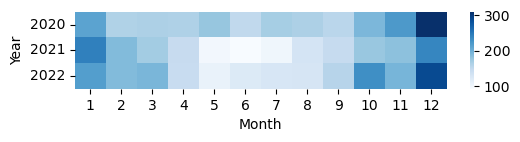

In [9]:
# We first show the number of pedestrian-related accident in each month across three years.
crosstab = pd.crosstab(Pedestrian_accident.Year, Pedestrian_accident.Month)

plt.figure(figsize=(6,1))
sns.heatmap(crosstab,cmap="Blues")
plt.show()

In 2021.05-07, there was a third-degree lockdown in Taiwan because of Covid-19. So there is a lower number of accidents. Besides that, there is still have higher number in winter of accidents that involve pedestrians.

Later, we will see if there is a high frequency in time within different months.

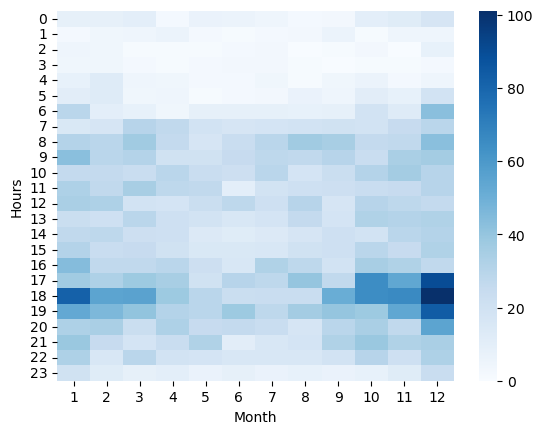

In [10]:
crosstab = pd.crosstab(Pedestrian_accident.Hours, Pedestrian_accident.Month)
sns.heatmap(crosstab,cmap="Blues")
plt.show()

We can see the time in hour 17-19 in winter significant high than other time periods.

Now, we only focus on time 17-19, to find out why in Autumn/Winter has more accident than Spring/Summer.

In [11]:
## create new columns with groups
grouping = [(Pedestrian_accident.Month.isin([3,4,5,6,7,8])),
            (Pedestrian_accident.Month.isin([9,10,11,12,1,2]))]

# 1:'Spring / Summer', 2:'Autumn / Winter'
new_group = [1, 2]

Pedestrian_accident.loc[:,'Season_g2'] = np.select(grouping, new_group, default=np.nan)

In [12]:
# Output the data in Hour 17-19
Hour_condition = (Pedestrian_accident.Hours >=17) & (Pedestrian_accident.Hours <= 19)

Pedestrian_accident_subgroup = Pedestrian_accident[Hour_condition]

counts = Pedestrian_accident_subgroup['Season_g2'].value_counts()
percentages = Pedestrian_accident_subgroup['Season_g2'].value_counts(normalize=True)*100
summary = pd.concat([counts,percentages], axis=1)
summary.columns = ['Count', 'Percentage']
codebook = {1:'Spring / Summer', 2:'Autumn / Winter'}
summary['Codebook'] = summary.index.map(codebook.get)
summary.sort_index()

,Count,Percentage,Codebook
Season_g2,,,
1.000,588,36.096,Spring / Summer
2.000,1041,63.904,Autumn / Winter


### Table 3: Factors between Spring/Summer and Autumn/Winter in Hour 17-19.

In [13]:
# Crosstab with chi-squared test p-value within Spring/Summer and Autumn/Winter in Hour 17-19
def chi2_PedSeason(col, codebook):
    crosstab = pd.crosstab(Pedestrian_accident_subgroup[col], Pedestrian_accident_subgroup.Season_g2)
    chi2, p, dof, expected = chi2_contingency(crosstab)
    crosstab['Codebook'] = crosstab.index.map(codebook.get)
    
    print(crosstab)
    print(f'p-value: {p:.3f}')
    print('')

In [14]:
# Casue of accident
codebook = {1:'Driver - Improper driving at pedestrian crossing', 2:'Driver - Not paying enough attention',
            3:'Driver - Other causes', 4:'Pedestrians fail to comply with regulations', 5:'Unable to identify'}
chi2_PedSeason('Cause_major_gp', codebook)

# Weather condition
codebook = {1:'Sunny',2:'Cloudy',3:'Rainy'}
chi2_PedSeason('Weather_gp', codebook)

# Light condition
codebook = {1:'Natural daylight',2:'Night or early morning'}
chi2_PedSeason('Light_gp', codebook)

# Road Surface condition
codebook = {0:'Dry',1:'Slippery'}
chi2_PedSeason('Road_surface', codebook)

# Road Type
codebook = {1:'Intersection',2:'Straight road',3:'Other'}
chi2_PedSeason('Road_type_gp', codebook)

# Road edge condition
codebook = {0:'With road edge',1:'Without road edge'}
chi2_PedSeason('Road_edge', codebook)

# Driver's vehicle
codebook = {1:'Bus or Truck', 2:'Sedan or Small Truck', 3:'Motorcycle or Scooter', 4:'Bicycle', 5:'Other or mix'}
chi2_PedSeason('Driver_vehicle', codebook)

# Day of the week
codebook = {True:'Weekend', False:'Weekday'}
chi2_PedSeason('is_Weekend', codebook)

# Location
codebook = {1:'North', 2:'West', 3:'South', 4:'East', 5:'Central'}
chi2_PedSeason('Location', codebook)

Season_g2       1.0  2.0                                          Codebook
Cause_major_gp                                                            
1.000           224  402  Driver - Improper driving at pedestrian crossing
2.000           133  234              Driver - Not paying enough attention
3.000            67  108                             Driver - Other causes
4.000            85  117       Pedestrians fail to comply with regulations
5.000            79  133                                Unable to identify
p-value: 0.587

Season_g2   1.0  2.0 Codebook
Weather_gp                   
1           359  388    Sunny
2            96  216   Cloudy
3           133  437    Rainy
p-value: 0.000

Season_g2  1.0  2.0                Codebook
Light_gp                                   
1          227  136        Natural daylight
2          361  905  Night or early morning
p-value: 0.000

Season_g2     1.0  2.0  Codebook
Road_surface                    
0             447  581       Dry
1 

#### Next, we are going to analyse pedestrian individual data.
- First, deal with the missing value.
- Second, use undersampling and SMOTE to deal with the target imbalance.
- Third, train the Rondom Forest model to find the more significant features.

In [15]:
# Show where the missing values are
PINA = Pedestrian_individual.isna().sum()
print('Missing value in Pedestrain_individual data')
print(PINA[PINA>0])

Missing value in Pedestrain_individual data
Cause_major_gp     142
nDrive_license     208
Driver_drinking    479
dtype: int64


In [16]:
# Show which injury level has missing value
Pedestrian_individual[Pedestrian_individual.isna().any(axis=1)].Injury_level.value_counts().sort_index()

Injury_level
0.000      1
1.000      2
2.000    595
3.000     11
Name: count, dtype: int64

*Most missing values are in injury group and is about 10%, we will dropna for the later analysis*

In [17]:
# Drop the missing values
Pedestrian_individual_clean = Pedestrian_individual.dropna()
len(Pedestrian_individual_clean)

5720

In [18]:
# Show the target's count in clean data
Pedestrian_individual_clean.Injury_level.value_counts().sort_index()

Injury_level
0.000      72
1.000      26
2.000    5361
3.000     261
Name: count, dtype: int64

Smapling coding refered to Jason Brownlee, PhD. (https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

In [19]:
## Deal with target's imbalance with undersampling and oversampling
# Create data with features and target
PI_X = Pedestrian_individual_clean.drop(['Injury_level','Accident_no'],axis=1)
PI_y = Pedestrian_individual_clean['Injury_level'].astype(int)

# Correct the Categorical Data types for the later analysis
cat_col = ['Cause_major_gp', 'Weather_gp', 'Light_gp', 'Road_surface', 'Road_edge',
           'Road_type_gp', 'Season', 'is_Weekend', 'Hour_gp', 'Location', 'Sex', 'Driver_vehicle', 
           'Multiple_driver', 'nDrive_license', 'Driver_drinking', 'hit_and_run', 'Driver_sex']

PI_X.loc[:,cat_col] = PI_X[cat_col].astype('object')

# Use non-injury group as my target size
target_size = 261

# SMOTE sampler for two death groups (group 0 and 1)
smote = SMOTE(sampling_strategy={i: target_size for i in (0,1)})

# Undersample for injury gorup (group 2)
under = RandomUnderSampler(sampling_strategy={2: target_size})

# Create an imbalanced-learn pipeline to combine SMOTE and undersampling
resampling_pipeline = Pipeline([('smote', smote), ('under', under)])

PIX_resampled, PIy_resampled = resampling_pipeline.fit_resample(PI_X, PI_y)
PIy_resampled.value_counts().sort_index()

Injury_level
0    261
1    261
2    261
3    261
Name: count, dtype: int64

In [20]:
## We will use 80% of data to train the model and 20% of data as test set
# Split the data into training and testing dataset with 80/20 percent rule
X_train, X_test, y_train, y_test = train_test_split(PIX_resampled, PIy_resampled, test_size=0.2, 
                                                    random_state=261, stratify=PIy_resampled)

## Train the Random Forest model and evaluate the test result
rf_model = RandomForestClassifier(n_estimators=100, random_state=26)

# Use 10-fold cross-validation for training and prediction
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
predictions = cross_val_predict(rf_model, X_train, y_train, cv=cv)

rf_model.fit(X_train, y_train)
test_predictions = rf_model.predict(X_test)

# Calculate accuracy for training and testing
train_accuracy = accuracy_score(y_train, predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

Training Accuracy: 0.786
Test Accuracy: 0.818


## Figure 3, 4

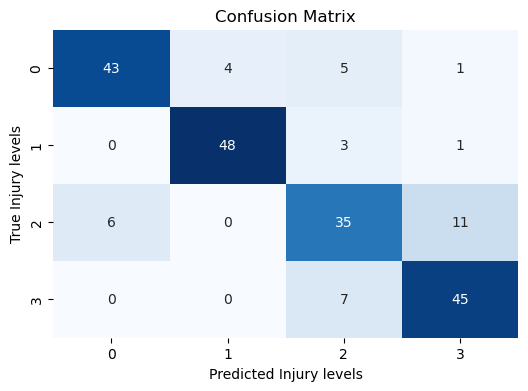

In [21]:
# Plot the confusion matrix with test result
cm = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Injury levels')
plt.ylabel('True Injury levels')
plt.title('Confusion Matrix')
plt.show()

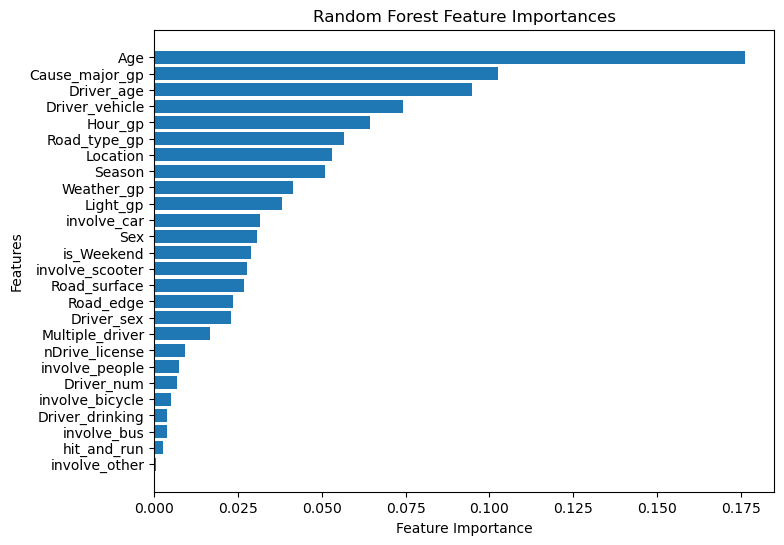

In [22]:
# Output the feature's importances
feature_importances = rf_model.feature_importances_
feature_names = PIX_resampled.columns
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.show()

#### Later, I will use the resampled data to evaluate the top five importances features.
- Age
- Cause of accident
- Driver's age
- Driver's vehicle
- Time of the day

### Figure 5

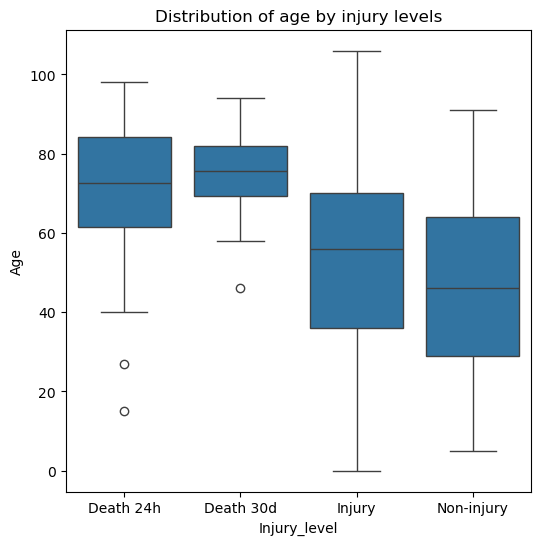

In [23]:
# Age
plt.figure(figsize=(6, 6))
sns.boxplot(y=Pedestrian_individual_clean.Age, x=Pedestrian_individual_clean.Injury_level)
plt.xticks(np.arange(4),['Death 24h','Death 30d', 'Injury','Non-injury'])
plt.title('Distribution of age by injury levels')
plt.show()

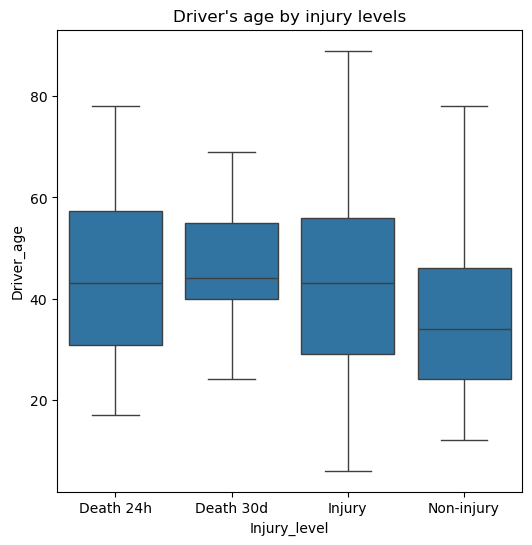

In [24]:
# Driver's Age
plt.figure(figsize=(6, 6))
sns.boxplot(y=Pedestrian_individual_clean.Driver_age, x=Pedestrian_individual_clean.Injury_level)
plt.xticks(np.arange(4),['Death 24h','Death 30d', 'Injury','Non-injury'])
plt.title("Driver's age by injury levels")
plt.show()

In [25]:
## Deal with target's imbalance with undersampling to better show the importance factors within 4 groups
# Create data with features and target
T5_X = Pedestrian_individual_clean[['Age','Driver_age','Cause_major_gp','Hour_gp','Driver_vehicle']]
T5_y = Pedestrian_individual_clean['Injury_level'].astype(int)

# Correct the Categorical Data types for the later analysis
cat_col = ['Cause_major_gp','Hour_gp','Driver_vehicle']

T5_X.loc[:,cat_col] = T5_X[cat_col].astype('object')

# Use death 30 days group as my target size
target_size = 26

# Undersample for other gorups
under_sampler = RandomUnderSampler(sampling_strategy={i: target_size for i in (0,2,3)})

# Combined resampling
T5X_resampled, T5y_resampled = under_sampler.fit_resample(PI_X, PI_y)
T5y_resampled.value_counts().sort_index()

Injury_level
0    26
1    26
2    26
3    26
Name: count, dtype: int64

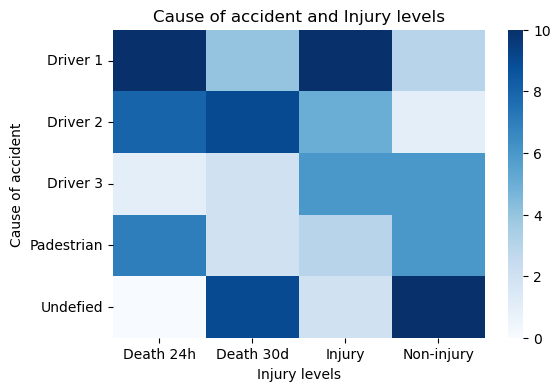

In [26]:
# Cause of accident
crosstab = pd.crosstab(T5X_resampled.Cause_major_gp, T5y_resampled)

plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(crosstab, annot=False, cmap="Blues")

heatmap.set_xticklabels(['Death 24h','Death 30d', 'Injury','Non-injury'])
heatmap.set_yticklabels(['Driver 1','Driver 2', 'Driver 3','Padestrian','Undefied'],rotation=0)

plt.xlabel('Injury levels')
plt.ylabel('Cause of accident')
plt.title('Cause of accident and Injury levels')

plt.show()

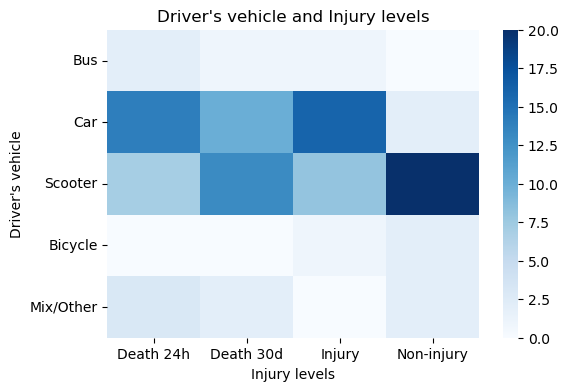

In [27]:
# Driver's vehicle
crosstab = pd.crosstab(T5X_resampled.Driver_vehicle, T5y_resampled)

plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(crosstab, annot=False, cmap="Blues",)

heatmap.set_xticklabels(['Death 24h','Death 30d', 'Injury','Non-injury'])
heatmap.set_yticklabels(['Bus','Car', 'Scooter','Bicycle','Mix/Other'],
                        rotation=0)

plt.xlabel('Injury levels')
plt.ylabel("Driver's vehicle")
plt.title("Driver's vehicle and Injury levels")
plt.show()

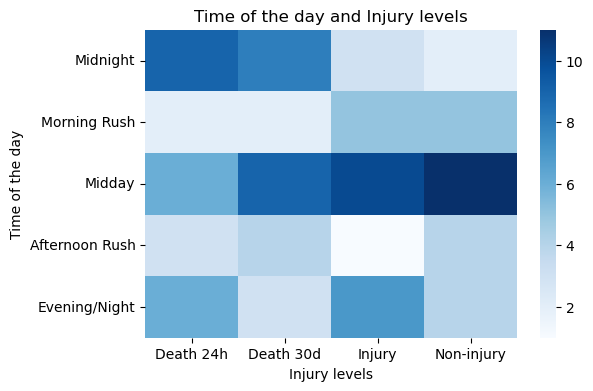

In [28]:
# Time of the day
crosstab = pd.crosstab(T5X_resampled.Hour_gp,T5y_resampled)

plt.figure(figsize=(6, 4))

heatmap = sns.heatmap(crosstab, annot=False, cmap="Blues")

heatmap.set_xticklabels(['Death 24h','Death 30d', 'Injury','Non-injury'])
heatmap.set_yticklabels(['Midnight','Morning Rush','Midday','Afternoon Rush','Evening/Night'],rotation=0)

plt.xlabel('Injury levels')
plt.ylabel("Time of the day")
plt.title("Time of the day and Injury levels")
plt.show()

### Figure 6

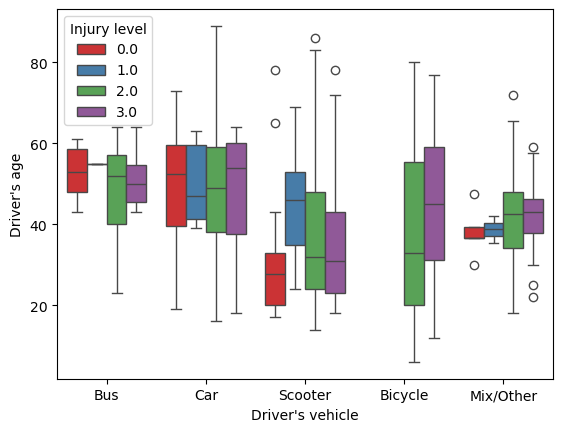

In [29]:
# Driver's age with Driver's vehicle in injury levels
sns.boxplot(y=Pedestrian_individual_clean.Driver_age, x=Pedestrian_individual_clean.Driver_vehicle, 
            hue=Pedestrian_individual_clean.Injury_level, palette='Set1')
plt.xticks(np.arange(5),['Bus','Car', 'Scooter','Bicycle','Mix/Other'])
plt.legend(title='Injury level')
plt.xlabel("Driver's vehicle")
plt.ylabel("Driver's age")
plt.show()

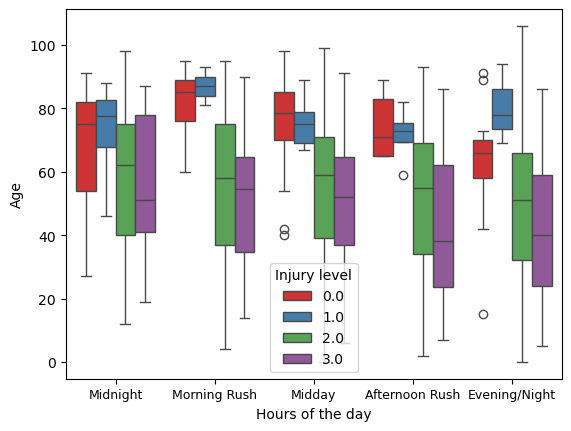

In [30]:
# Age with time of the accidents in injury levels
sns.boxplot(y=Pedestrian_individual_clean.Age, x=Pedestrian_individual_clean.Hour_gp, 
            hue=Pedestrian_individual_clean.Injury_level, palette='Set1')
plt.xticks(np.arange(5),['Midnight','Morning Rush','Midday','Afternoon Rush','Evening/Night'],fontsize=9)
plt.legend(title='Injury level')
plt.xlabel("Hours of the day")
plt.ylabel("Age")
plt.show()

*Supplemental Figures for two factors in injury severity*

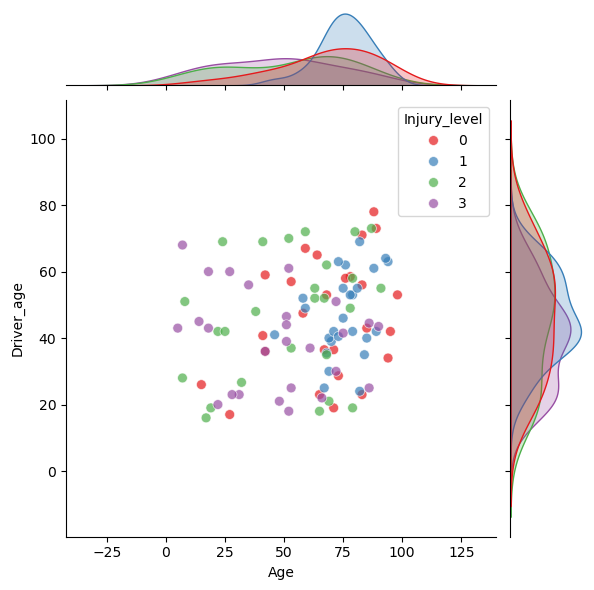

In [31]:
# Age with Driver's age in injury levels
sns.jointplot(x=T5X_resampled.Age,y=T5X_resampled.Driver_age,hue=T5y_resampled, palette='Set1',s=50, alpha=0.7)
plt.show()

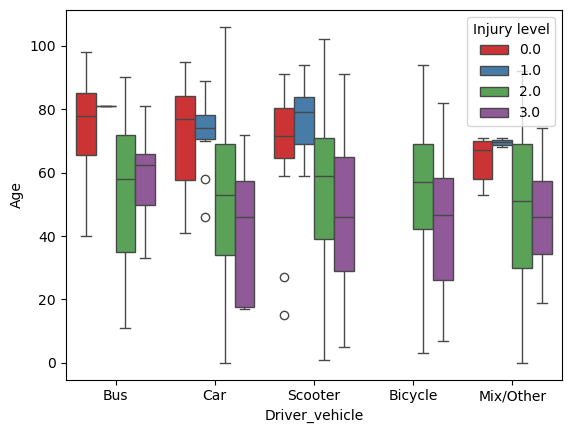

In [32]:
# Age with Driver's vehicle in injury levels
sns.boxplot(y=Pedestrian_individual_clean.Age, x=Pedestrian_individual_clean.Driver_vehicle, 
            hue=Pedestrian_individual_clean.Injury_level, palette='Set1')
plt.xticks(np.arange(5),['Bus','Car', 'Scooter','Bicycle','Mix/Other'])
plt.legend(title='Injury level')
plt.show()

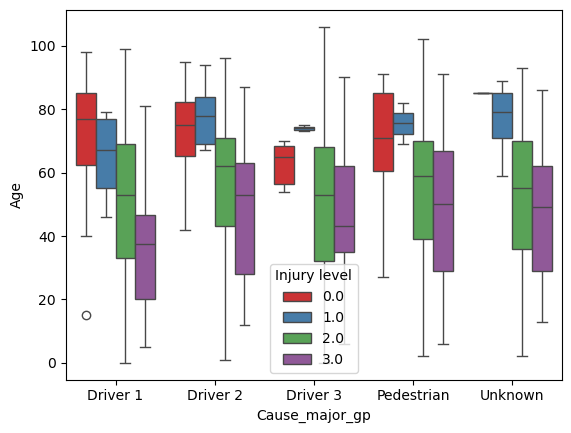

In [33]:
# Age with Cause of accident in injury levels
sns.boxplot(y=Pedestrian_individual_clean.Age, x=Pedestrian_individual_clean.Cause_major_gp, 
            hue=Pedestrian_individual_clean.Injury_level, palette='Set1')
plt.xticks(np.arange(5),['Driver 1','Driver 2', 'Driver 3','Pedestrian','Unknown'])
plt.legend(title='Injury level')
plt.show()

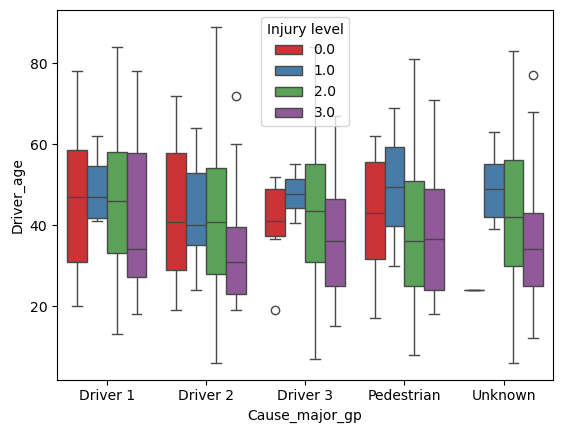

In [34]:
# Driver's age with Driver's vehicle in injury levels
sns.boxplot(y=Pedestrian_individual_clean.Driver_age, x=Pedestrian_individual_clean.Cause_major_gp, 
            hue=Pedestrian_individual_clean.Injury_level, palette='Set1')
plt.xticks(np.arange(5),['Driver 1','Driver 2', 'Driver 3','Pedestrian','Unknown'])
plt.legend(title='Injury level')
plt.show()

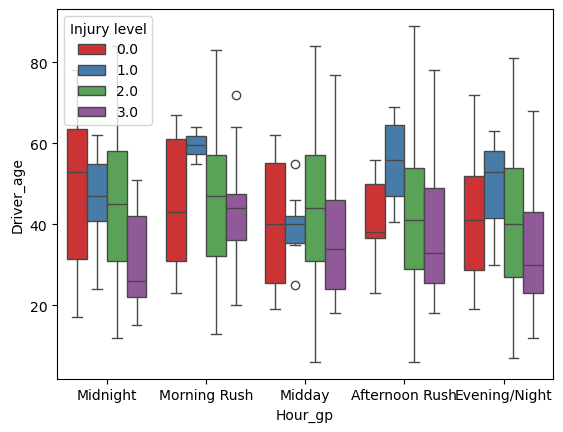

In [35]:
# Driver's age with time of the accident in injury levels
sns.boxplot(y=Pedestrian_individual_clean.Driver_age, x=Pedestrian_individual_clean.Hour_gp, 
            hue=Pedestrian_individual_clean.Injury_level, palette='Set1')
plt.xticks(np.arange(5),['Midnight','Morning Rush','Midday','Afternoon Rush','Evening/Night'])
plt.legend(title='Injury level')
plt.show()